## Notebook description/goals

Check that porting SKOG code to SalishSeaCast went ok


##### SalishSeaCast changeset:   changeset:   1513:bc72ffe711fa

##### run changeset: 2083:fd6a3ea984cd 

##### run dir: nemo3.6/tereza/SKOG_debug/v3_SSC

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import sys
sys.path.append('/data/tjarniko/MEOPAR/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/VIZ')
import mocsy
import VIZ_plots as VP

import time
import numpy as np
import matplotlib.pyplot as plt
from oct2py import octave
import seawater as sw
from __future__ import print_function
from numpy import *
from scipy import *
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import reload
plt.style.use('seaborn-white')
import netCDF4 as nc
import numpy as np
import cmocean as cm

""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

%matplotlib inline

In [3]:
reload(VP)

<module 'VIZ_plots' from '/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/VIZ/VIZ_plots.py'>

## Printouts of diagnostics from point 250, 250 at timestep 0 

In [12]:
tda = 's18_4/'
resdir = ('/data/tjarniko/results/' + tda)
carpstr = 'SalishSea_1ts_20170101_20170101_carp_T_20170101-20170101.nc'
gridstr = 'SalishSea_1ts_20170101_20170101_grid_T_20170101-20170101.nc' 
gridwstr = 'SalishSea_1ts_20170101_20170101_grid_W_20170101-20170101.nc'
     
carp = nc.Dataset(resdir+carpstr)
grid = nc.Dataset(resdir+gridstr)
gridw = nc.Dataset(resdir+gridwstr)
     

# temp = grid.variables['votemper'][:]
# sal = grid.variables['vosaline'][:]
# #print('temp: ', temp[0,0,250,250])
# #print('sal: ', sal[0,0,250,250])

In [21]:
visc = gridw.variables['vert_eddy_visc']
x = 230
y = 600
print(visc[0,:,y,x])

[  0.00000000e+00   6.65543717e-04   1.52974746e-06   1.35737730e-06
   1.76765241e-06   9.20580987e-06   1.09254252e-05   9.99999997e-07
   9.99999997e-07   9.99999997e-07   9.99999997e-07   9.99999997e-07
   9.99999997e-07   9.99999997e-07   9.99999997e-07   9.99999997e-07
   9.99999997e-07   9.99999997e-07   9.99999997e-07   9.99999997e-07
   9.99999997e-07   9.99999997e-07   9.99999997e-07   1.13785541e-06
   2.59436706e-06   2.34589425e-06   1.14012403e-06   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]


In [22]:
v = 1e-5
D = 500
f = 1.114*10-4

Ek = v

In [5]:
td = carp

f_ph = td.variables['f_ph'][:]
f_pco2w = td.variables['f_pco2w'][:]
wind_mag = td.variables['wind_mag'][:]
f_omarg = td.variables['f_omarg'][:]
f_co2flux = td.variables['f_co2flux'][:]
f_dpco2 = td.variables['f_dpco2'][:]
dar = [f_ph, f_pco2w, f_omarg, f_co2flux, wind_mag, f_dpco2]

darn = ['f_ph', 'f_pco2w', 'f_omarg', 'f_co2flux', 'wind_mag', 'f_dpco2']

for i in range(0,len(dar)):
    print(darn[i])
    print(dar[i][0,250,250])

f_ph
7.70582
f_pco2w
861.594
f_omarg
0.765893
f_co2flux
-0.000812292
wind_mag
8.53794
f_dpco2
453.841


          kwco2 = kw660 * (660./schmidtco2)**0.5

    !     Surface K0 [(mol/kg) / atm] at T, S of surface water
          CALL surface_K0(temp, sal, N, & ! INPUT
          K0)                             ! OUTPUT

    !     "Atmospheric" [CO2*], air-sea CO2 flux, sfc DIC rate of change, & Delta pCO2
    !     all "lifted" from the gasx.f90 function of MOCSY
          co2starair = K0 * fco2atm * 1.0e-6_wp * rhoSW ! Equil. [CO2*] for atm CO2 at Patm & sfc-water T,S [mol/m3]
          co2star    = co2                              ! Oceanic [CO2*] in [mol/m3] from vars.f90
          co2flux    = kwco2 * (co2starair - co2star)   ! Air-sea CO2 flux [mol/(m2 * s)]
    !     co2ex      = co2flux / dz1                    ! Change in sfc DIC due to gas exchange [mol/[m3 * s)]
          dpco2      = pco2 - pco2atm                   ! Delta pCO2 (oceanic - atmospheric pCO2) [uatm]

In [6]:
def flux_maps(carp,grid, ddmmmyy, rdir,humandate, dss_sig):
    
    twind = carp.variables['wind_mag'][0,:,:]
    ttemp = grid.variables['votemper'][0,0,:,:]
    tdic = carp.variables['dissolved_inorganic_carbon'][0,0,:,:]
    tpco2 = carp.variables['f_pco2w'][0,:,:]
    co2flux = carp.variables['f_co2flux'][0,:,:] * -1
    dpco2 = carp.variables['f_dpco2'][0,:,:]
    
    surf_dat = [twind, ttemp, tdic, tpco2, co2flux, dpco2]
    
    
    vmins = [0,0,1200,400,-2e-4,-800]
    vmaxs = [8,10,2200,1200,2e-4,800]
    msk = [0,0,0,0,0,0]
    cl = ['wind m/s', 'temp (deg C)', 'DIC umol', 'uatm', 'CO2 flux [mol/(m2 * s)]', 'dpco2']
    t_cmap = [cm.cm.tempo, cm.cm.thermal, cm.cm.matter, cm.cm.matter, cm.cm.curl, cm.cm.curl]

    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = \
    plt.subplots(figsize=(20, 27) , nrows=2, ncols=3)

    viz_tools.set_aspect(ax1)
    viz_tools.set_aspect(ax2)
    viz_tools.set_aspect(ax3)
    viz_tools.set_aspect(ax4)
    viz_tools.set_aspect(ax5)
    viz_tools.set_aspect(ax6)

    i = 0
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax1.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax1)
    cbar.set_label(cl[i], fontsize = 20 )

    i = 1
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax2.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax2)
    cbar.set_label(cl[i], fontsize = 20 )

    i = 2
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax3.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax3)
    cbar.set_label(cl[i], fontsize = 20 )

    i = 3
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax4.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax4)
    cbar.set_label(cl[i], fontsize = 20 )

    i = 4
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax5.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax5)
    cbar.set_label(cl[i], fontsize = 20 )

    i = 5
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax6.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax6)
    cbar.set_label(cl[i], fontsize = 20 )



    #tcmap.set_bad('white')
    st = 'Salish Sea Carbonate Chemistry Flux Map, ' + humandate
    plt.suptitle(st,fontsize=20)
    
    fname = rdir + f'{ddmmmyy}_map_' + dss_sig +'.png'

    plt.show()
    #fig.savefig(fname)
    #plt.close()

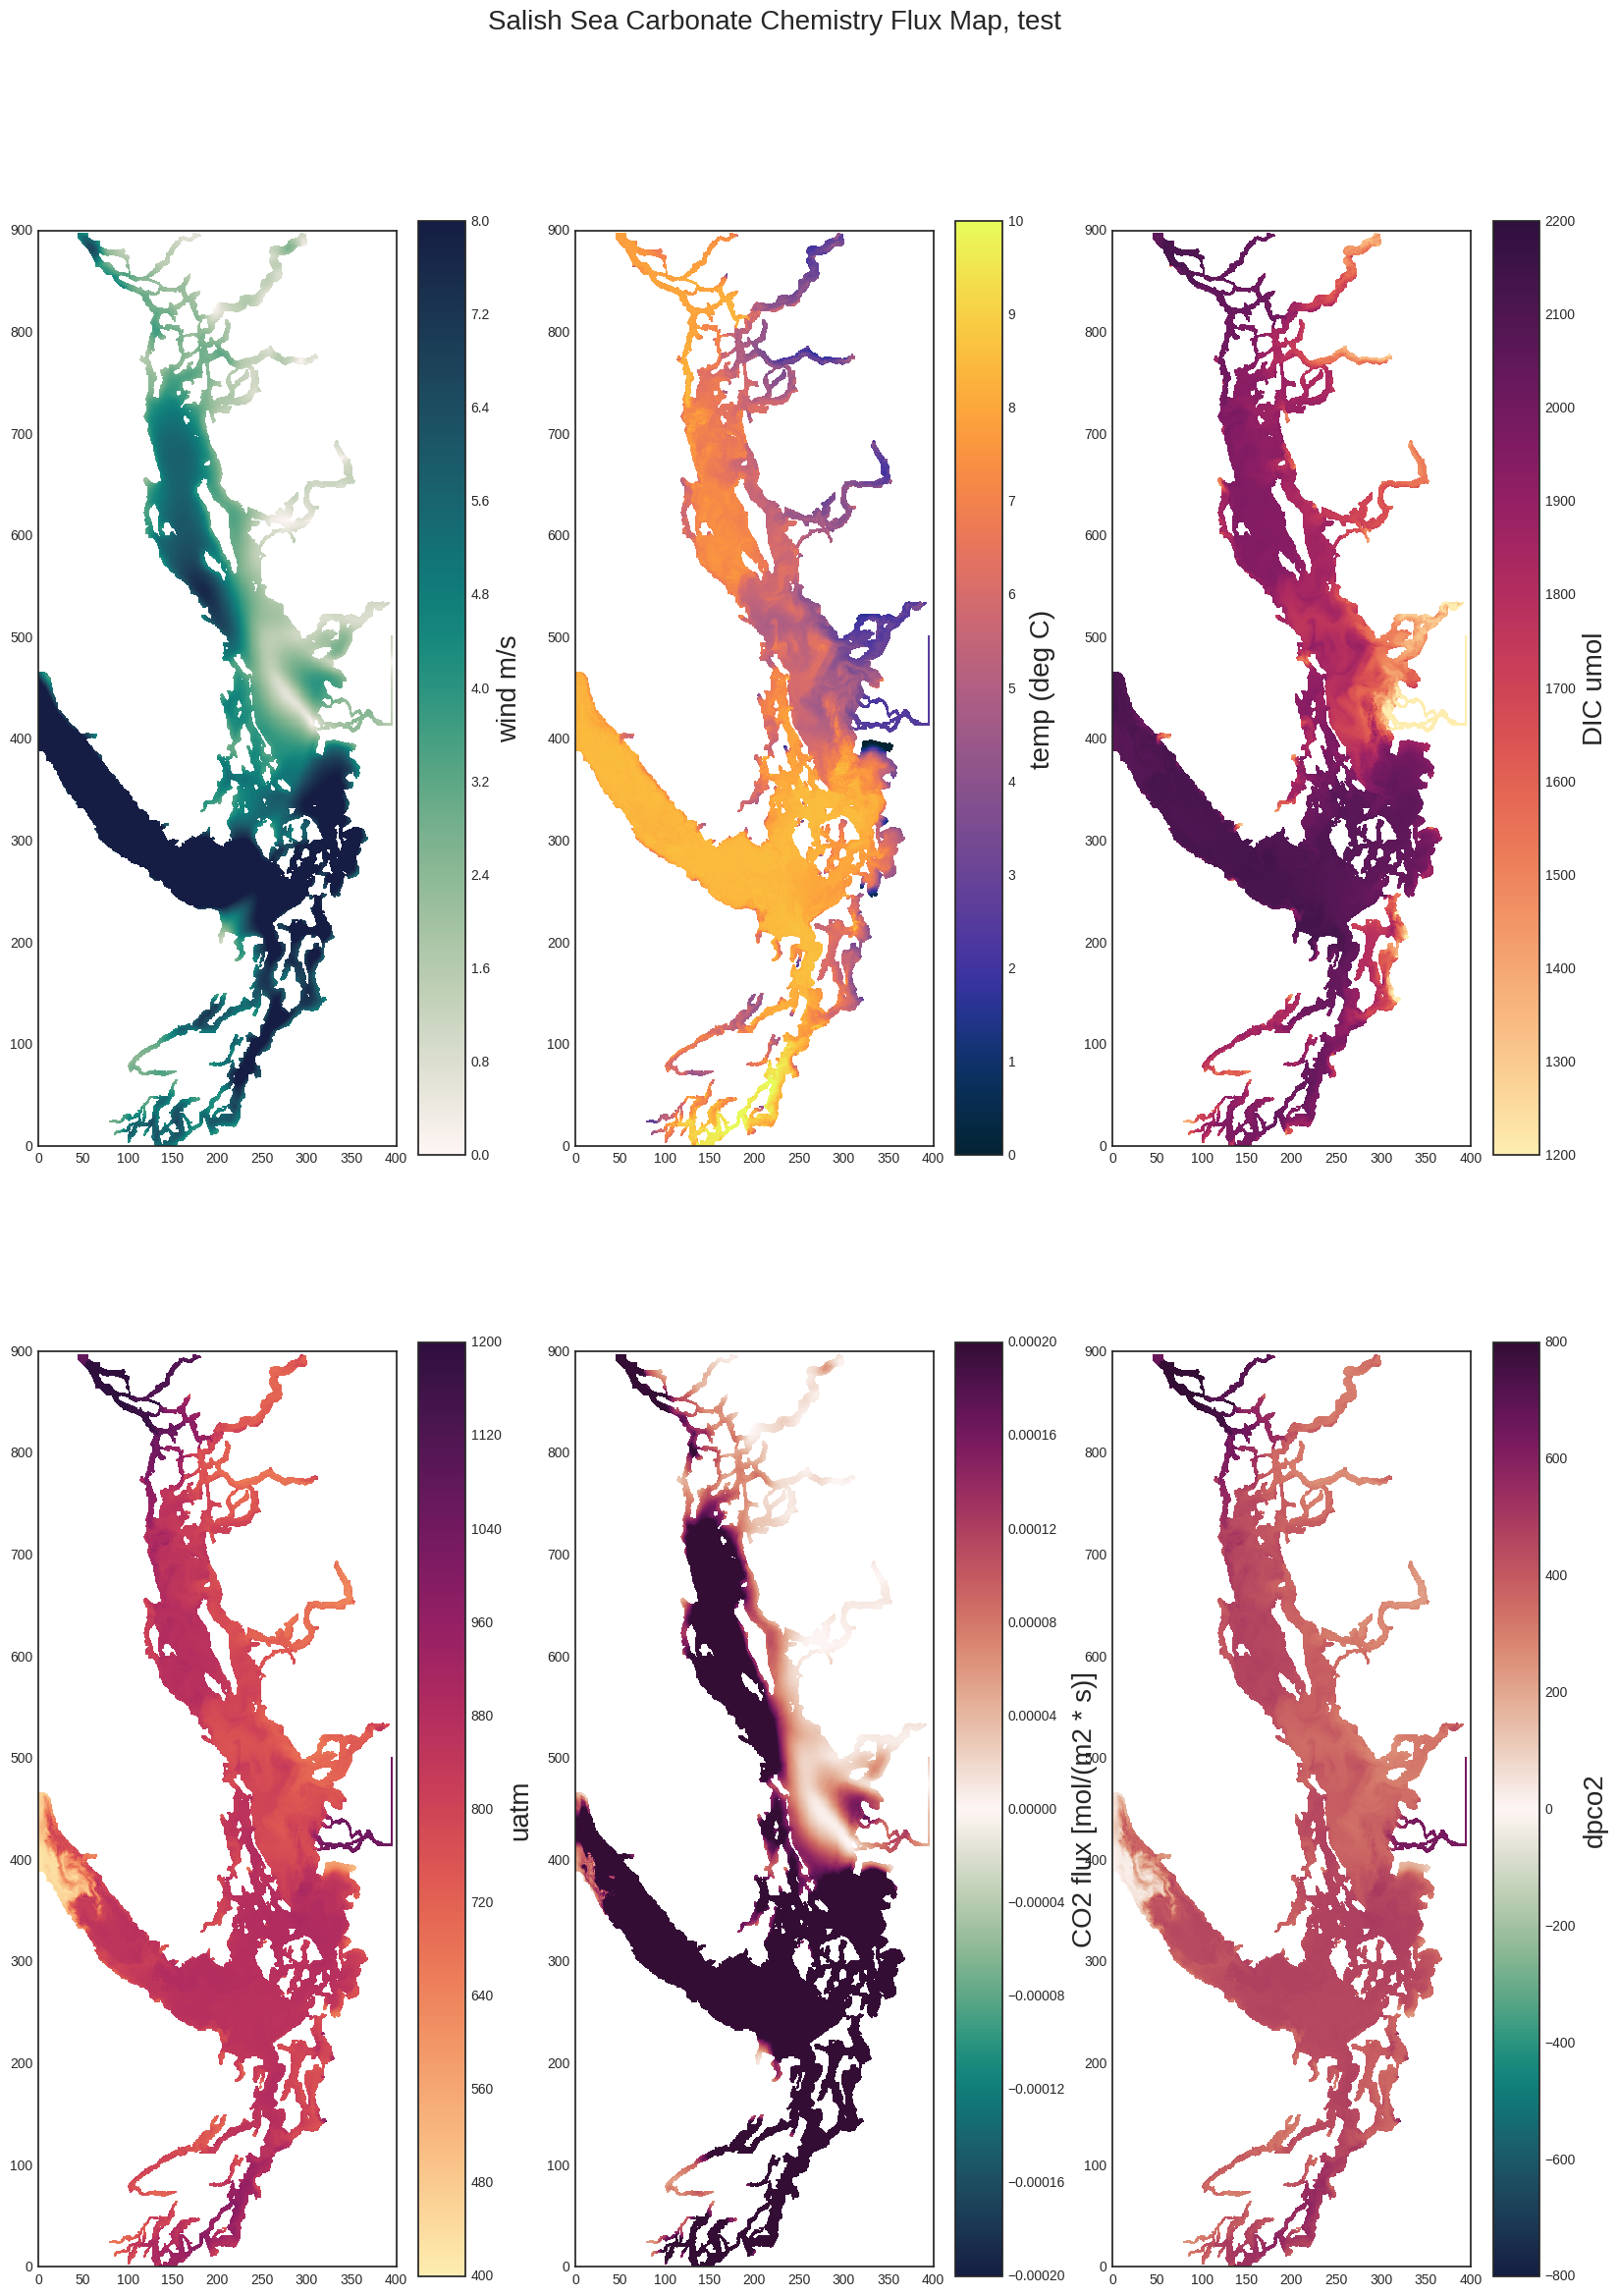

In [7]:
flux_maps(carp,grid, '000', './','test', 'dss_sig')

In [8]:
def flux_maps_412(carp,grid, ddmmmyy, rdir,humandate, dss_sig):
    
    twind = carp.variables['wind_mag'][0,:,:]
    ttemp = grid.variables['votemper'][0,0,:,:]
    tdic = carp.variables['dissolved_inorganic_carbon'][0,0,:,:]
    tpco2 = carp.variables['f_pco2w'][0,:,:]
    co2flux = carp.variables['f_co2flux'][0,:,:] * -1
    dpco2 = carp.variables['f_dpco2'][0,:,:]
    
    surf_dat = [twind, ttemp, tdic, tpco2, co2flux, dpco2]
    
    
    vmins = [0,6,1200,412,-2e-4,-800]
    vmaxs = [8,27,2200,413,2e-4,800]
    msk = [0,0,0,0,0,0]
    cl = ['wind m/s', 'temp (deg C)', 'DIC umol', 'uatm', 'co2flux', 'dpco2']
    t_cmap = [cm.cm.tempo, cm.cm.thermal, cm.cm.matter, cm.cm.matter, cm.cm.curl, cm.cm.curl]

    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = \
    plt.subplots(figsize=(20, 27) , nrows=2, ncols=3)

    viz_tools.set_aspect(ax1)
    viz_tools.set_aspect(ax2)
    viz_tools.set_aspect(ax3)
    viz_tools.set_aspect(ax4)
    viz_tools.set_aspect(ax5)
    viz_tools.set_aspect(ax6)

    i = 0
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax1.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax1)
    cbar.set_label(cl[i], fontsize = 20 )

    i = 1
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax2.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax2)
    cbar.set_label(cl[i], fontsize = 20 )

    i = 2
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax3.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax3)
    cbar.set_label(cl[i], fontsize = 20 )

    i = 3
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax4.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax4)
    cbar.set_label(cl[i], fontsize = 20 )

    i = 4
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax5.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax5)
    cbar.set_label(cl[i], fontsize = 20 )

    i = 5
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax6.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax6)
    cbar.set_label(cl[i], fontsize = 20 )



    #tcmap.set_bad('white')
    st = 'Salish Sea Carbonate Chemistry Flux Map, ' + humandate
    plt.suptitle(st,fontsize=20)
    
    fname = rdir + f'{ddmmmyy}_map_' + dss_sig +'.png'

    plt.show()
    #fig.savefig(fname)
    #plt.close()

### Check - direction of flux should fulcrum on 412 uatm..

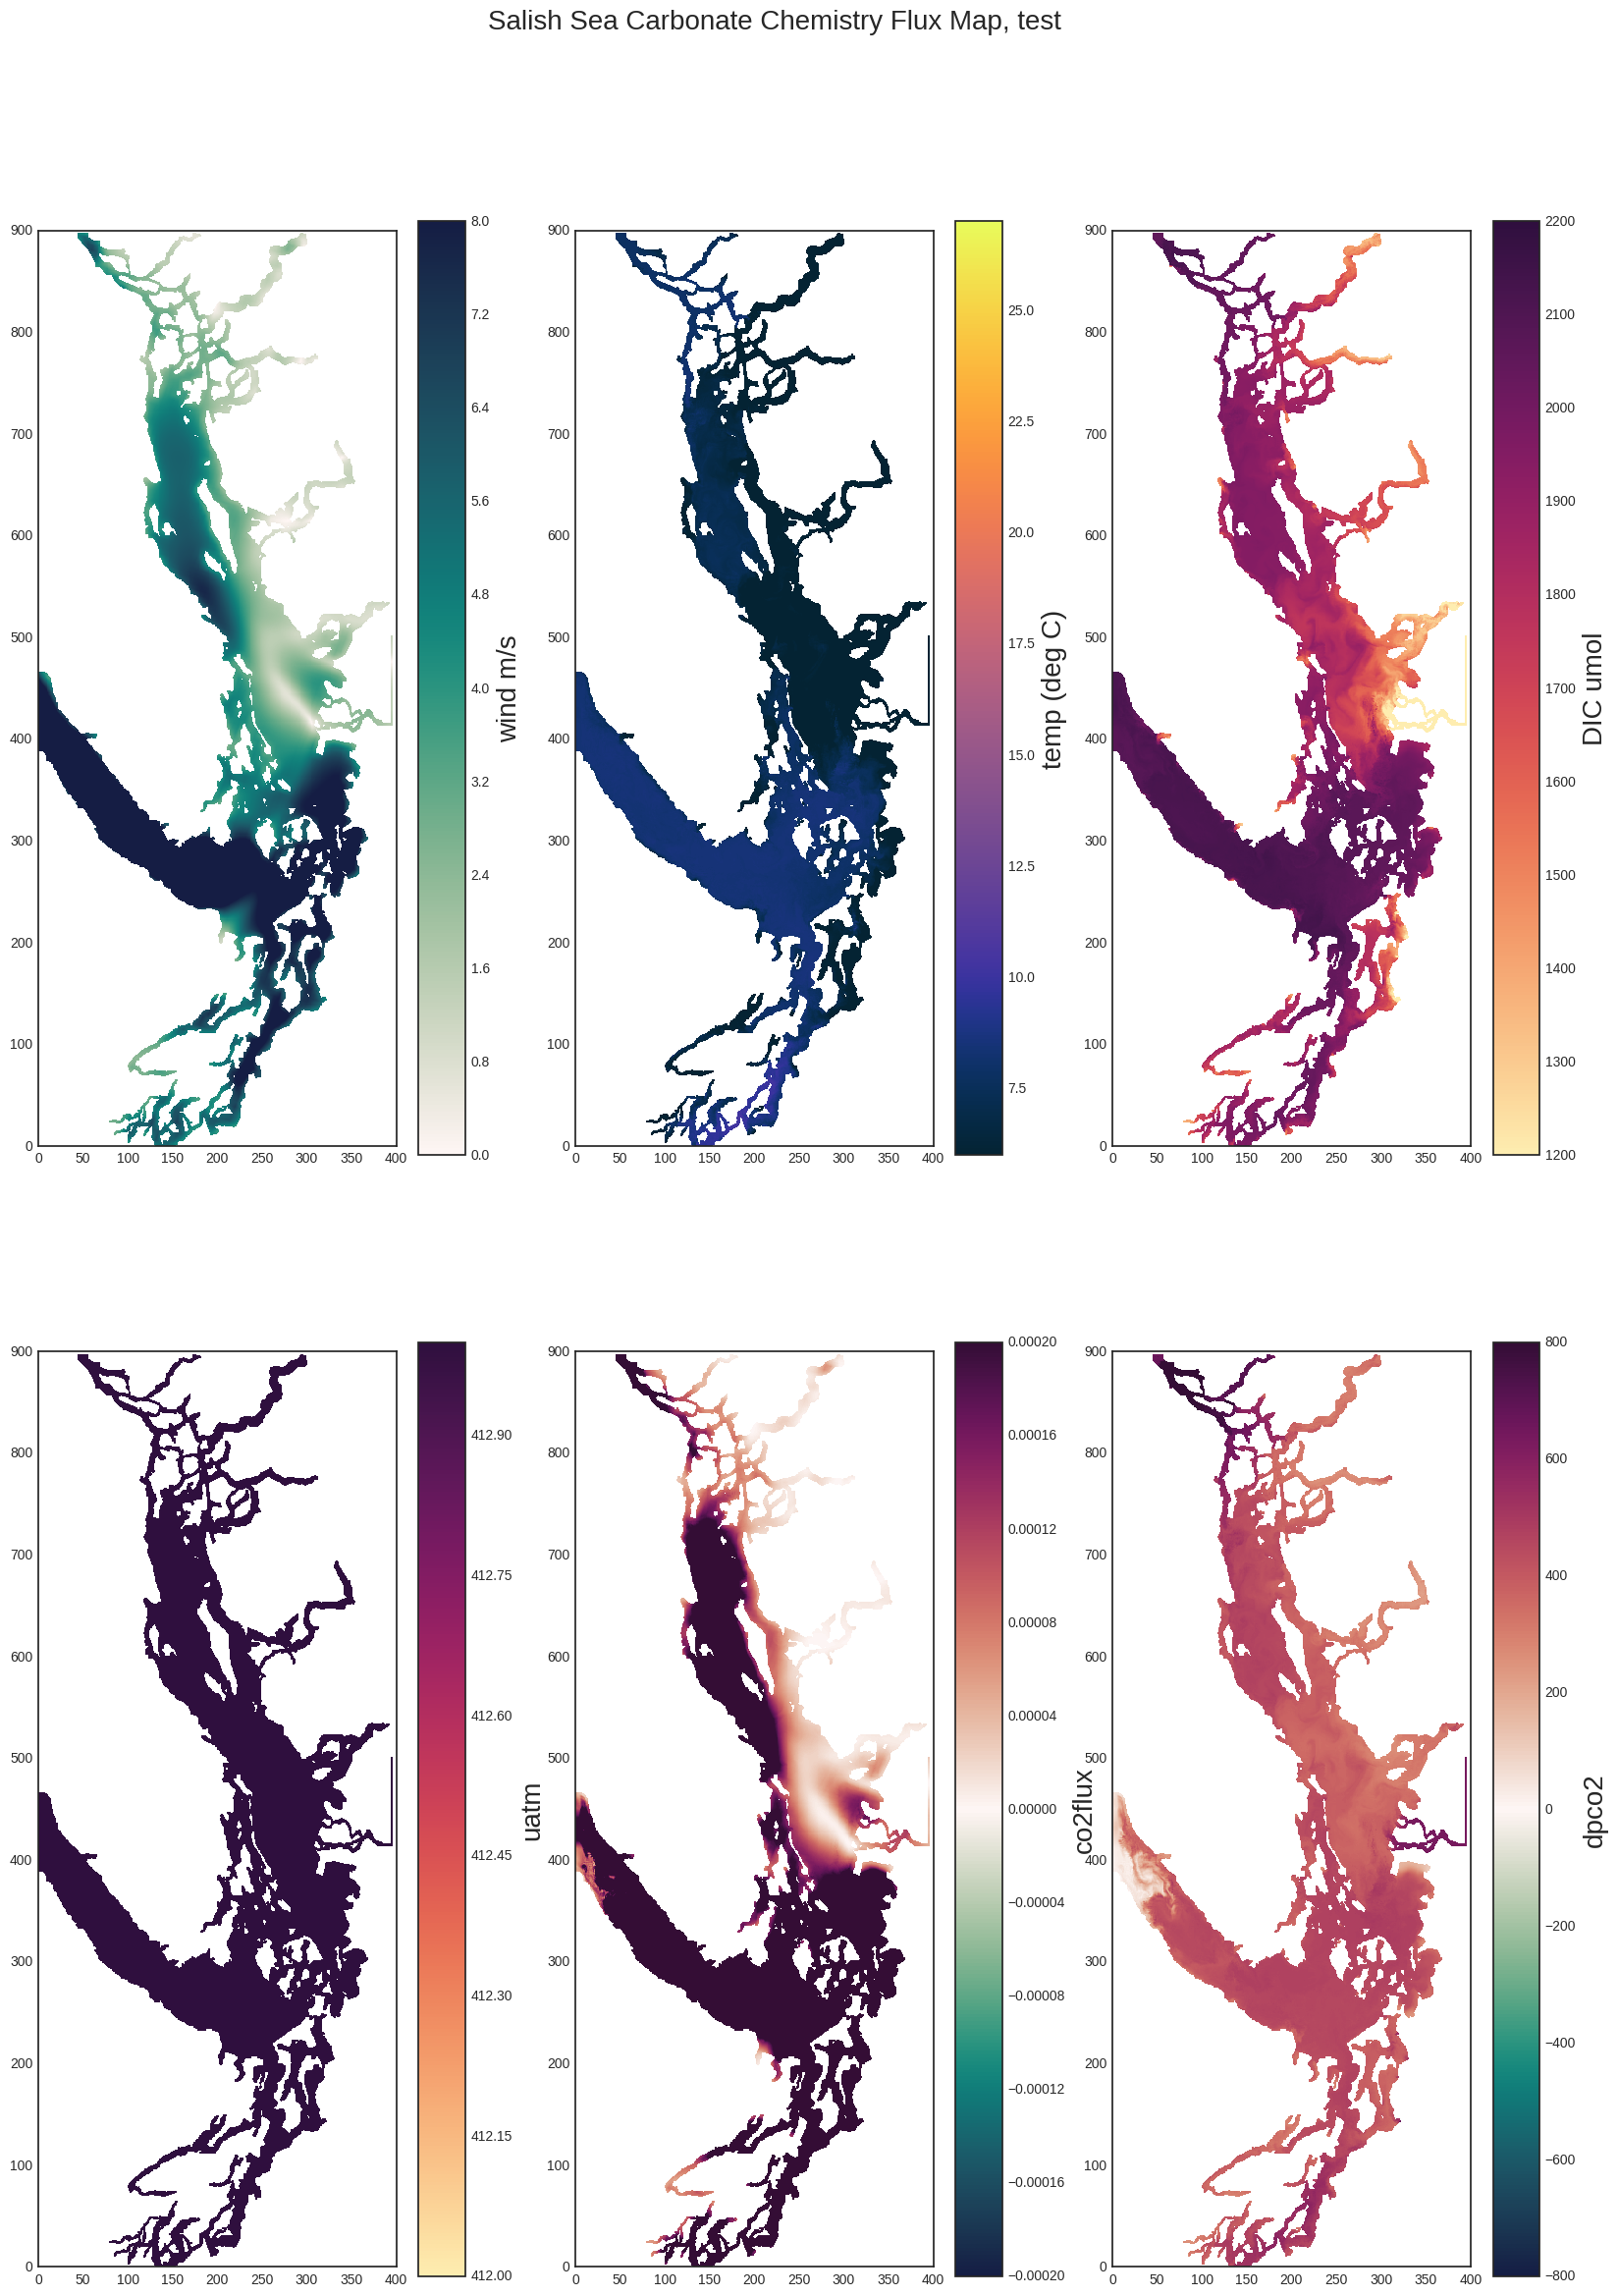

In [9]:
flux_maps_412(carp,grid, '000', './','test', 'dss_sig')

In [10]:
w = nc.Dataset('/data/tjarniko/MEOPAR/SS-run-sets/SalishSea/nemo3.6/tereza/INIT_NC/SalishSea_01684800_restart_trc.nc')
print(w)


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    file_name: SalishSea_01684800_restart_trc.nc
    TimeStamp: 20/08/2018 03:33:06 -0700
    dimensions(sizes): x(398), y(898), z(40), t(1)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 nav_lev(z), float64 time_counter(t), float64 kt(), float64 ndastp(), float64 adatrj(), float64 rnf_pis_NO3_b(t,y,x), float64 rnf_pis_NH4_b(t,y,x), float64 rnf_pis_Si_b(t,y,x), float64 rnf_pis_DIAT_b(t,y,x), float64 rnf_pis_PHY_b(t,y,x), float64 rnf_pis_MYRI_b(t,y,x), float64 rnf_pis_MICZ_b(t,y,x), float64 rnf_pis_DON_b(t,y,x), float64 rnf_pis_PON_b(t,y,x), float64 rnf_pis_bSi_b(t,y,x), float64 rnf_pis_TRA_b(t,y,x), float64 rnf_pis_DIC_b(t,y,x), float64 rnf_pis_TA_b(t,y,x), float64 rnf_pis_O2_b(t,y,x), float64 sbc_NO3_b(t,y,x), float64 sbc_NH4_b(t,y,x), float64 sbc_Si_b(t,y,x), float64 sbc_DIAT_b(t,y,x), float64 sbc_PHY_b(t,y,x), float64 sbc_MYRI_b(t,y,x), float64 sbc_MICZ_b(t,y,x), flo